# Regression with Fourier Features - Part 2

Initially observed in: https://arxiv.org/abs/2006.10739

The inclusion of Fourier features allows neural networks to capture high frequency information of the target function. In this short note, we compare a vanilla DNN with another Fourier-feature embedded DNN on the task of learning a (noise-perturbed) PDE solution in both space and time domains. The Fourier features embedding is done in both directions and results are aggregated.

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
from collections import OrderedDict

# set random seeds
np.random.seed(10)
torch.manual_seed(10);
torch.set_default_dtype(torch.float64)

import numpy as np    
import matplotlib.pyplot as plt

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

# import neural nets
from PINN.utils.dnn import *

Generate data from the following PDE:
$$
    \frac{\partial u}{\partial t} + u_0\sin(\omega t)\frac{\partial u}{\partial x} = 0
$$ whose analytical solution is given by:
$$
    u(t,x) = \exp\bigg(
            -k[x - x_0 - 2v_0\omega^{-1}\sin^2(\frac{1}{2}\omega t)]^2
        \bigg)
$$

In [2]:
# parameters
x0 = 2.0
v0 = 2.0
k = 5.0
omega = 2.0*np.pi
# time grid
t_start = 0.0
t_end = 2*np.pi
dt = 0.001
tgrid = np.arange(t_start, t_end, dt)
nt = len(tgrid)
# spatial grid
x_left, x_right = 0.0, 5.0
dx = 0.005
xgrid = np.arange(x_left, x_right, dx)
nx = len(xgrid)

# solution
u_sol = np.zeros([nt, nx])
for i in range(nt):
    t = tgrid[i]
    u_sol[i, :] = np.exp(-k * (( xgrid - x0 ) - (2*v0/omega) * (np.sin(0.5*omega*t) ** 2)) ** 2 )

# subsample grids
subsample_t = 6
subsample_x = 2
xgrid_small = xgrid.reshape(1, -1)[:, 0:-1:subsample_x].squeeze(),
tgrid_small = tgrid.reshape(1, -1)[:, 0:-1:subsample_t].squeeze()
u_sol_small = u_sol[0:-1:subsample_t, 0:-1:subsample_x]
print(u_sol_small.shape)

(1048, 500)


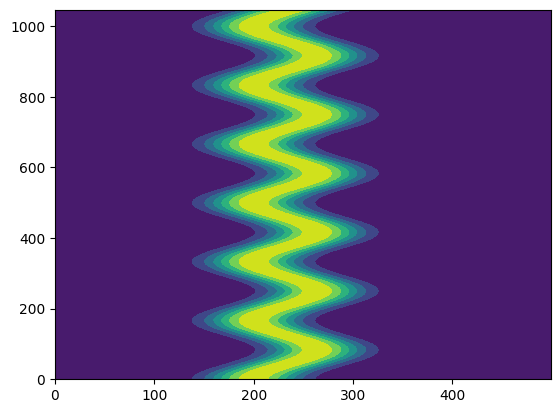

In [3]:
plt.figure(1);
plt.contourf(u_sol_small);

In [4]:
# create training data
X = cartesian_data(torch.tensor(tgrid_small.flatten()), torch.tensor(xgrid_small[0].flatten()))
y = torch.tensor(u_sol_small).T.flatten().reshape(-1, 1)
#y = torch.tensor(u_sol_small2).T.flatten().reshape(-1, 1)

# define training function
def train(inputs, outputs, model, optim, scheduler, batch_size, epochs, shuffle=True):
    X, y = inputs, outputs
    nx = X.shape[0]
    num_batches = int(nx/batch_size)
    all_iteration_errors = []
    for i in range(epochs):
        print("============================================================\n")
        print("Epoch = {}\n".format(i+1));
        print("============================================================\n")
        model.train()
        if shuffle:
            tmp = np.random.permutation(nx)
            X, y = X[tmp, :].data.clone(), y[tmp, :].data.clone()
        for idx in range(num_batches):
            if idx % 100 == 0:
                print("| => | Batch {} |\n".format(idx+1))
        # closure definition
            def closure():
                optim.zero_grad()
                start_idx = idx*batch_size
                end_idx = (idx+1)*batch_size
                if idx + 1 == num_batches:
                    # if last batch
                    end_idx = -1
                Xb, yb = X[start_idx:end_idx, :].data.clone(), y[start_idx:end_idx, :].data.clone()

                # require gradients
                Xb.requires_grad = True
                # make a prediction on the batch
                y_pred = model.forward(Xb)
                # compute L^2 loss
                loss = torch.mean((y_pred - yb)**2)
                # backpropagate
                loss.backward()
                if idx % 100 == 0:
                    print("==> Batch {} loss = {}".format(idx, loss.item()))
                # append error for each iteration
                all_iteration_errors.append(loss.item())
                return loss
            optim.step(closure=closure)
        if scheduler:
            # step scheduler after epoch if there is one
            scheduler.step()
            print("---------- \n")
            print("++ Learning rate reduced, now at = {}".format(scheduler.get_last_lr()[0]))
    return all_iteration_errors

In [5]:
# test vanilla neural net
nn_vanilla = DNN(layers=[2, 200, 200, 200, 1])
nn_vanilla

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=2, out_features=200, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=200, out_features=200, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [ ]:
optim = torch.optim.Adam(
    nn_vanilla.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_vanilla, optim, scheduler, 2**12, 50, shuffle=True)

In [ ]:
# make predictions and compare contour plots
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict = nn_vanilla(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict);
ax[1].contourf(u_sol_exact);

In [ ]:
# testing Fourier embedded net in 2d
nn_fourier2d = FourierEmbeddedDNN2d(
    100,
    4, 
    1,
    m=15, 
    freq_stds={"time": [1.0, 2.0, 5.0, 10.0], "space": [1.0]}
)
optim = torch.optim.Adam(
    nn_fourier2d.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_fourier2d, optim, scheduler, 2**12, 50, shuffle=True)

In [ ]:
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict_fourier = nn_fourier2d(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact_fourier = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict_fourier)
ax[1].contourf(u_sol_exact_fourier)

In [ ]:
np.mean((u_sol_predict_fourier-u_sol_exact_fourier)**2)

In [ ]:
# testing Fourier embedded net in 2d (old architecture)
nn_fourier2d_old = FourierEmbeddedDNN2dOld(
    layers=[40, 128, 128, 128, 1],
    m=20, 
    freq_stds=np.array([[1.,2.,10.,20.,100.], [1.,2.,10.,20.,100.]]).T
)
optim = torch.optim.Adam(
    nn_fourier2d_old.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_fourier2d_old, optim, scheduler, 2**12, 50, shuffle=True)

In [ ]:
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict_fourier = nn_fourier2d_old(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact_fourier = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict_fourier)
ax[1].contourf(u_sol_exact_fourier)

In [ ]:
np.mean((u_sol_predict_fourier-u_sol_exact_fourier)**2)

In [6]:
# test fourier net in 2d with cartesian product features
# testing Fourier embedded net in 2d (old architecture)
nn_fourier2d_cartesian = FourierProductEmbeddedDNN2d(
    layers_time=[40, 128, 128, 1], 
    layers_space=[40, 100, 100, 1], 
    activation=torch.nn.Tanh, 
    last_layer_activation=None, 
    mt=20, 
    mx=20, 
    freq_stds_t=[1.,2.,10.,20.,100.], 
    freq_stds_x=[1., 2., 5., 10.]
)
optim = torch.optim.Adam(
    nn_fourier2d_cartesian.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
info = train(X, y, nn_fourier2d_cartesian, optim, scheduler, 2**12, 200, shuffle=True)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 0.1666057608393436
| => | Batch 101 |

==> Batch 100 loss = 0.005811716443929872
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 0.002942203228620698
| => | Batch 101 |

==> Batch 100 loss = 0.0019345292102701545
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 0.0018963087424980454
| => | Batch 101 |

==> Batch 100 loss = 0.0015919163156018507
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 0.0015306328167339497
| => | Batch 101 |

==> Batch 100 loss = 0.001281618814537252
---------- 

++ Learning rate reduced, now at = 0.007996800479968

Epoch = 5


| => | Batch 1 |

==> Batch 0 loss = 0.0011825336496329745
| => | Batch 101 |

==> Batch 100 loss = 0.0010094727160862575
---------- 

++ Learning rate reduced, now at = 0.007996000799920003


| => | Batch 101 |

==> Batch 100 loss = 0.00014585023375275302
---------- 

++ Learning rate reduced, now at = 0.007979225979211954

Epoch = 27


| => | Batch 1 |

==> Batch 0 loss = 0.0001382511112571656
| => | Batch 101 |

==> Batch 100 loss = 9.198868401791805e-05
---------- 

++ Learning rate reduced, now at = 0.007978428056614032

Epoch = 28


| => | Batch 1 |

==> Batch 0 loss = 9.544063059195816e-05
| => | Batch 101 |

==> Batch 100 loss = 0.0001103850199832818
---------- 

++ Learning rate reduced, now at = 0.007977630213808371

Epoch = 29


| => | Batch 1 |

==> Batch 0 loss = 0.0001218052702334089
| => | Batch 101 |

==> Batch 100 loss = 0.00010759209473361954
---------- 

++ Learning rate reduced, now at = 0.00797683245078699

Epoch = 30


| => | Batch 1 |

==> Batch 0 loss = 9.685816062460287e-05
| => | Batch 101 |

==> Batch 100 loss = 0.00010839284174359517
---------- 

++ Learning rate reduced, now at = 0.007976034767541912

Epoch = 31


| => | Batch 1 |

==> Batch 0 lo

| => | Batch 101 |

==> Batch 100 loss = 9.891623478333214e-05
---------- 

++ Learning rate reduced, now at = 0.007959301833599735

Epoch = 52


| => | Batch 1 |

==> Batch 0 loss = 9.264280091581784e-05
| => | Batch 101 |

==> Batch 100 loss = 0.0001272810190545263
---------- 

++ Learning rate reduced, now at = 0.007958505903416374

Epoch = 53


| => | Batch 1 |

==> Batch 0 loss = 0.00012252553616920318
| => | Batch 101 |

==> Batch 100 loss = 9.062904579419019e-05
---------- 

++ Learning rate reduced, now at = 0.007957710052826033

Epoch = 54


| => | Batch 1 |

==> Batch 0 loss = 0.00010422871902019675
| => | Batch 101 |

==> Batch 100 loss = 0.00012097199395724513
---------- 

++ Learning rate reduced, now at = 0.007956914281820751

Epoch = 55


| => | Batch 1 |

==> Batch 0 loss = 9.334011697089872e-05
| => | Batch 101 |

==> Batch 100 loss = 8.881880088376538e-05
---------- 

++ Learning rate reduced, now at = 0.00795611859039257

Epoch = 56


| => | Batch 1 |

==> Batch 0 lo

---------- 

++ Learning rate reduced, now at = 0.007939427438624915

Epoch = 77


| => | Batch 1 |

==> Batch 0 loss = 9.611576616802626e-05
| => | Batch 101 |

==> Batch 100 loss = 0.00010864262448775762
---------- 

++ Learning rate reduced, now at = 0.007938633495881052

Epoch = 78


| => | Batch 1 |

==> Batch 0 loss = 8.269354746854026e-05
| => | Batch 101 |

==> Batch 100 loss = 0.00012314128689893154
---------- 

++ Learning rate reduced, now at = 0.007937839632531463

Epoch = 79


| => | Batch 1 |

==> Batch 0 loss = 0.00011285877955515404
| => | Batch 101 |

==> Batch 100 loss = 0.00013653114857861606
---------- 

++ Learning rate reduced, now at = 0.00793704584856821

Epoch = 80


| => | Batch 1 |

==> Batch 0 loss = 8.812435700588113e-05
| => | Batch 101 |

==> Batch 100 loss = 0.000101520649185798
---------- 

++ Learning rate reduced, now at = 0.007936252143983354

Epoch = 81


| => | Batch 1 |

==> Batch 0 loss = 8.403506631936614e-05
| => | Batch 101 |

==> Batch 100 lo

| => | Batch 101 |

==> Batch 100 loss = 8.78977277897289e-05
---------- 

++ Learning rate reduced, now at = 0.00791881070979302

Epoch = 103


| => | Batch 1 |

==> Batch 0 loss = 0.0001030747728461099
| => | Batch 101 |

==> Batch 100 loss = 0.00010195249391846476
---------- 

++ Learning rate reduced, now at = 0.00791801882872204

Epoch = 104


| => | Batch 1 |

==> Batch 0 loss = 8.67620355009906e-05
| => | Batch 101 |

==> Batch 100 loss = 8.112519997345313e-05
---------- 

++ Learning rate reduced, now at = 0.007917227026839167

Epoch = 105


| => | Batch 1 |

==> Batch 0 loss = 8.470618177816973e-05
| => | Batch 101 |

==> Batch 100 loss = 9.772820611532394e-05
---------- 

++ Learning rate reduced, now at = 0.007916435304136483

Epoch = 106


| => | Batch 1 |

==> Batch 0 loss = 9.76121830662258e-05
| => | Batch 101 |

==> Batch 100 loss = 8.068917045296896e-05
---------- 

++ Learning rate reduced, now at = 0.00791564366060607

Epoch = 107


| => | Batch 1 |

==> Batch 0 loss

| => | Batch 101 |

==> Batch 100 loss = 7.738690682881872e-05
---------- 

++ Learning rate reduced, now at = 0.007899037421247413

Epoch = 128


| => | Batch 1 |

==> Batch 0 loss = 8.584017188920394e-05
| => | Batch 101 |

==> Batch 100 loss = 0.000103739885790812
---------- 

++ Learning rate reduced, now at = 0.00789824751750529

Epoch = 129


| => | Batch 1 |

==> Batch 0 loss = 9.668625541150987e-05
| => | Batch 101 |

==> Batch 100 loss = 0.00014030864485885914
---------- 

++ Learning rate reduced, now at = 0.007897457692753539

Epoch = 130


| => | Batch 1 |

==> Batch 0 loss = 9.865656658952744e-05
| => | Batch 101 |

==> Batch 100 loss = 8.270067355432191e-05
---------- 

++ Learning rate reduced, now at = 0.007896667946984263

Epoch = 131


| => | Batch 1 |

==> Batch 0 loss = 8.928218379735544e-05
| => | Batch 101 |

==> Batch 100 loss = 8.060717616526369e-05
---------- 

++ Learning rate reduced, now at = 0.007895878280189565

Epoch = 132


| => | Batch 1 |

==> Batch 0 

| => | Batch 101 |

==> Batch 100 loss = 0.0009645705751516642
---------- 

++ Learning rate reduced, now at = 0.007879313506648764

Epoch = 153


| => | Batch 1 |

==> Batch 0 loss = 0.00021674284792017572
| => | Batch 101 |

==> Batch 100 loss = 8.234757138628264e-05
---------- 

++ Learning rate reduced, now at = 0.007878525575298098

Epoch = 154


| => | Batch 1 |

==> Batch 0 loss = 7.388619089043455e-05
| => | Batch 101 |

==> Batch 100 loss = 7.918215755709153e-05
---------- 

++ Learning rate reduced, now at = 0.007877737722740568

Epoch = 155


| => | Batch 1 |

==> Batch 0 loss = 7.723309834797393e-05
| => | Batch 101 |

==> Batch 100 loss = 7.715033103910451e-05
---------- 

++ Learning rate reduced, now at = 0.007876949948968294

Epoch = 156


| => | Batch 1 |

==> Batch 0 loss = 7.509688134894887e-05
| => | Batch 101 |

==> Batch 100 loss = 7.206490941738254e-05
---------- 

++ Learning rate reduced, now at = 0.007876162253973397

Epoch = 157


| => | Batch 1 |

==> Batch 

---------- 

++ Learning rate reduced, now at = 0.007859638842710202

Epoch = 178


| => | Batch 1 |

==> Batch 0 loss = 8.450042885507081e-05
| => | Batch 101 |

==> Batch 100 loss = 8.360011747007598e-05
---------- 

++ Learning rate reduced, now at = 0.007858852878825932

Epoch = 179


| => | Batch 1 |

==> Batch 0 loss = 7.628806256555187e-05
| => | Batch 101 |

==> Batch 100 loss = 8.99537618335438e-05
---------- 

++ Learning rate reduced, now at = 0.007858066993538049

Epoch = 180


| => | Batch 1 |

==> Batch 0 loss = 0.00010319247456853776
| => | Batch 101 |

==> Batch 100 loss = 8.680926816751584e-05
---------- 

++ Learning rate reduced, now at = 0.007857281186838695

Epoch = 181


| => | Batch 1 |

==> Batch 0 loss = 8.528759365299312e-05
| => | Batch 101 |

==> Batch 100 loss = 8.042553348493913e-05
---------- 

++ Learning rate reduced, now at = 0.007856495458720011

Epoch = 182


| => | Batch 1 |

==> Batch 0 loss = 7.409321677907555e-05
| => | Batch 101 |

==> Batch 100

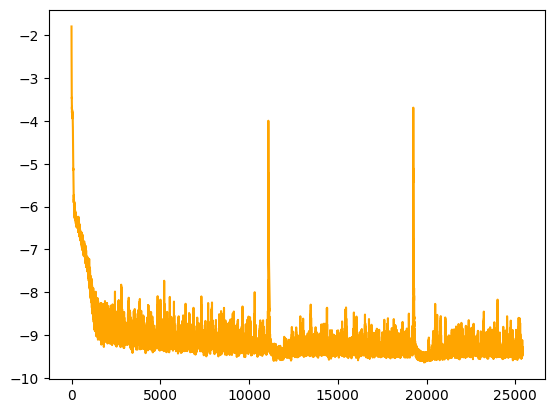

In [9]:
plt.plot(np.log(info), color="orange")

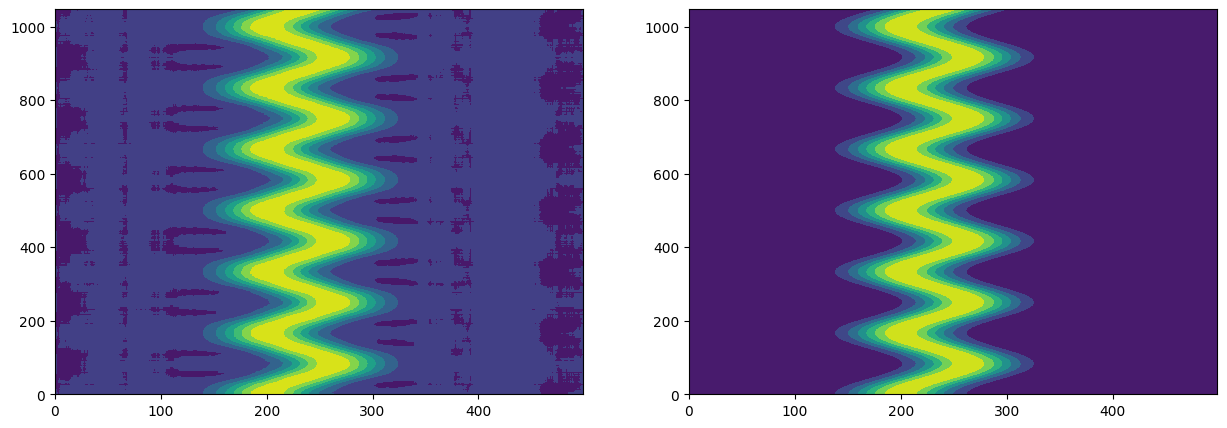

In [10]:
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict_fourier = nn_fourier2d_cartesian(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact_fourier = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict_fourier)
ax[1].contourf(u_sol_exact_fourier)

KeyboardInterrupt: 

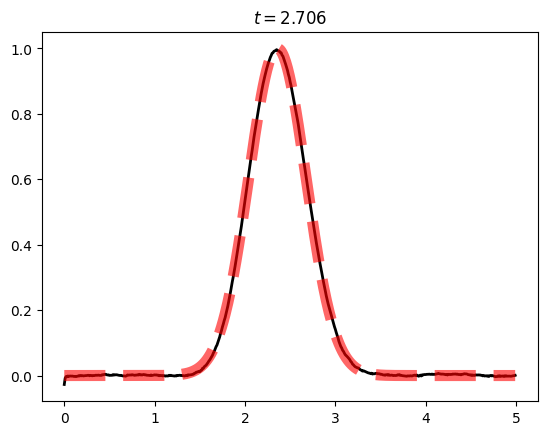

In [11]:
dt = tgrid_small[1]-tgrid_small[0]
for idx in range(nt_small):
    if idx % 5 == 0:
        plt.figure(1);
        plt.plot(xgrid_small[0].flatten(), u_sol_predict_fourier[idx, :], lw=2., color="black");
        plt.plot(xgrid_small[0].flatten(), u_sol_exact_fourier[idx, :], "--", lw=8.0, color="red", alpha=0.6);
        #plt.plot(xgrid_small[0].flatten(), u_sol_exact[idx, :], "--", lw=8.0, color="red", alpha=0.6);
        #plt.plot(xgrid_small[0].flatten(), u_sol_predict[idx, :], lw=2., color="blue", alpha=0.5);
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.clf()
        plt.title(r"$t = {}$".format(dt*(idx+1)))
        time.sleep(0.01);